In [1]:
!pip install scanpy scikit-misc --quiet

In [59]:
import scanpy as sc
import matplotlib.pyplot as plt
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
print('Scanpy version:', sc.__version__)

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

Scanpy version: 1.11.4


In [3]:
# !pip install scperturb --upgrade
# from scperturb import *

In [4]:
import sys
sys.path.append("..")
%reload_ext autoreload
%autoreload 2
from scperturb import *

# Prepare the data

In [5]:
# !wget https://zenodo.org/record/7041849/files/DatlingerBock2021.h5ad
file = '/scratch/peidli/scPerturb/DatlingerBock2021.h5ad'
adata = sc.read_h5ad(file)
adata

AnnData object with n_obs × n_vars = 39194 × 25904
    obs: 'sample', 'cell_line', 'perturbation', 'perturbation_2', 'tissue_type', 'cancer', 'celltype', 'disease', 'organism', 'perturbation_type', 'perturbation_type_2', 'ncounts', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts'
    var: 'ensembl_id', 'ncounts', 'ncells'

In [24]:
adata_real = sc.read_h5ad("/gpfs/home/asun/jin_lab/perturbench/raw_data/boli_ctx_scprocess_no+ctrl.h5ad")

In [25]:
adata_real = adata_real[
    (adata_real.obs['cell_type'] == 'L6_CT_CTX') & 
    (adata_real.obs['condition'].isin(['ctrl', 'SATB2', 'TBR1']))
].copy()

In [44]:
adata_pred = sc.read_h5ad("/gpfs/home/asun/jin_lab/perturbench/2_predict/logs/predict/runs/2025-10-08_11-43-57_boli_linear_baseline/predictions/prediction_chunk_0.h5ad")

In [45]:
adata_pred = adata_pred[
    (adata_pred.obs['cell_type'] == 'L6_CT_CTX') & 
    (adata_pred.obs['condition'].isin(['SATB2', 'TBR1']))
].copy()

In [42]:
adata_real.obs['condition'].value_counts()

condition
ctrl          689
TBR1_real     559
SATB2_real    551
Name: count, dtype: int64

In [46]:
adata_pred.obs['condition'].value_counts()

condition
SATB2    173
TBR1     173
Name: count, dtype: int64

In [31]:
adata_real.obs['condition'] = np.where(adata_real.obs['condition'] == "TBR1", "TBR1_real", adata_real.obs['condition'])
adata_real.obs['condition'] = np.where(adata_real.obs['condition'] == "SATB2", "SATB2_real", adata_real.obs['condition'])

In [47]:
adata_pred.obs['condition'] = np.where(adata_pred.obs['condition'] == "TBR1", "TBR1_pred", adata_pred.obs['condition'])
adata_pred.obs['condition'] = np.where(adata_pred.obs['condition'] == "SATB2", "SATB2_pred", adata_pred.obs['condition'])

In [48]:
adata = ad.concat(
    [adata_real, adata_pred],
    label="source",                 
    keys=["real", "pred"],          
    index_unique="-",               
)

In [14]:
adata.obs

,condition,cell_type,source
batch1_samp1_chan1_AAACCTGAGACAAAGG-1-real,BCL11B,L5_PT_CTX,real
batch1_samp1_chan1_AAACCTGAGGCCGAAT-1-real,BCL11B,L6b_CTX,real
batch1_samp1_chan1_AAACCTGCACGGTAAG-1-real,XPO7,L5_PT_CTX,real
batch1_samp1_chan1_AAACCTGCACTATCTT-1-real,XPO7,L6b_CTX,real
batch1_samp1_chan1_AAACCTGCAGGGCATA-1-real,TRIO,L6_CT_CTX,real
...,...,...,...
1898-pred,HERC1,L6_CT_CTX,pred
1899-pred,HERC1,L6_CT_CTX,pred
1900-pred,HERC1,L6_CT_CTX,pred
1901-pred,HERC1,L6_CT_CTX,pred


In [34]:
import scperturb as sp


In [49]:
adata_sub = sp.equal_subsampling(adata, 'condition', N_min=100)

In [50]:
adata_sub.obs['condition'].value_counts()

condition
ctrl          173
TBR1_real     173
SATB2_real    173
TBR1_pred     173
SATB2_pred    173
Name: count, dtype: int64

In [37]:
adata_sub

AnnData object with n_obs × n_vars = 2422 × 5000
    obs: 'condition', 'cell_type', 'source'

In [51]:
sc.pp.pca(adata_sub)
sc.pp.neighbors(adata_sub)

adata_sub.uns['processed'] = True

In [52]:
adata_sub

AnnData object with n_obs × n_vars = 865 × 5000
    obs: 'condition', 'cell_type', 'source'
    uns: 'pca', 'neighbors', 'processed'
    obsm: 'X_pca'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [40]:
estats = sp.edist(adata_sub, obs_key='condition', obsm_key='X_pca', dist='sqeuclidean')

100%|██████████| 105/105 [00:00<00:00, 420.16it/s]


In [53]:
df = sp.etest(adata_sub, obs_key='condition', obsm_key='X_pca', dist='sqeuclidean', control='ctrl', alpha=0.05, runs=1000, n_jobs=-1)

100%|██████████| 1000/1000 [00:25<00:00, 39.39it/s]
/gpfs/home/asun/miniforge3/envs/perturbench/lib/python3.11/site-packages/statsmodels/stats/multitest.py:186: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [56]:
df.loc[df.index=='ctrl', 'significant_adj'] = 'Control'
df['neglog10_pvalue_adj'] = -np.log10(df['pvalue_adj'])

/tmp/ipykernel_25163/881616230.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Control' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  df.loc[df.index=='ctrl', 'significant_adj'] = 'Control'


In [55]:
df

,edist,pvalue,significant,pvalue_adj,significant_adj
SATB2_pred,70.464321,0.001,True,0.004990,True
SATB2_real,1.899645,0.008,True,0.015936,True
TBR1_pred,71.214740,0.001,True,0.004990,True
TBR1_real,41.701660,0.001,True,0.004990,True
ctrl,0.000000,1.000,False,1.000000,False


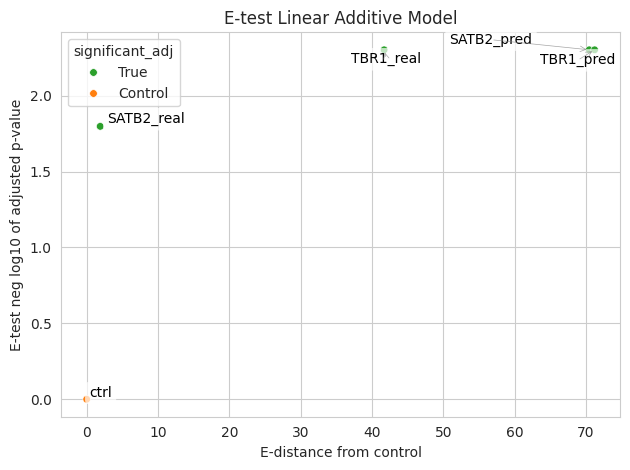

In [68]:
from adjustText import adjust_text

with sns.axes_style('whitegrid'):
    ax = sns.scatterplot(
        data=df,
        y='neglog10_pvalue_adj',
        x='edist',
        hue='significant_adj',
        palette={True: 'tab:green', False: 'tab:red', 'Control': 'tab:orange'},
        s=30
    )

texts = []
for idx, row in df.iterrows():
    texts.append(
        ax.text(
            row['edist'], 
            row['neglog10_pvalue_adj'], 
            str(idx),              
            fontsize=10,
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', edgecolor='none', alpha=0.7)  # 배경 추가
        )
    )

adjust_text(
    texts, 
    ax=ax, 
    arrowprops=dict(arrowstyle="->", color="gray", lw=0.5, alpha=0.7),
    expand_text=(1, 1),         
    force_text=1.0,            
    force_points=0.5,          
    lim=2000,                  
    avoid_self=True,
    autoalign='xy',            
    ha='center',               
    va='center'                
)

plt.title('E-test Linear Additive Model')
plt.xlabel('E-distance from control')
plt.ylabel('E-test neg log10 of adjusted p-value')
plt.tight_layout()
plt.show()

In [41]:
estats

condition,ctrl,TBR1_real,SATB2_real,BCL11B,XPO7,TRIO,ANK3,TBR1_pred,SATB2_pred,CUL1,RB1CC1,DAB1,CX3CL1,HERC1
condition,,,,,,,,,,,,,,
ctrl,0.000000,46.490069,1.571149,60.797348,69.156288,60.952423,65.258979,68.794202,67.136924,73.920503,64.107659,59.046503,64.463005,63.109431
TBR1_real,46.490069,0.000000,45.729692,102.205199,109.145311,100.373285,105.102122,87.274573,106.725244,114.530111,103.507439,101.898975,107.489100,107.553437
SATB2_real,1.571149,45.729692,0.000000,66.498508,72.940545,65.175732,68.499980,71.896978,70.450008,78.644715,67.460954,63.364243,67.656206,66.422604
BCL11B,60.797348,102.205199,66.498508,0.000000,1.590286,0.988033,1.541176,4.334443,1.729550,6.425950,2.422047,0.644035,1.868454,2.079405
XPO7,69.156288,109.145311,72.940545,1.590286,0.000000,0.676240,-0.097088,3.812964,0.318206,4.806199,1.315212,0.295579,-0.095197,0.340070
TRIO,60.952423,100.373285,65.175732,0.988033,0.676240,0.000000,0.299917,3.045191,0.849920,7.035060,1.116280,-0.055928,0.474367,1.150591
ANK3,65.258979,105.102122,68.499980,1.541176,-0.097088,0.299917,0.000000,3.351542,-0.000427,6.006686,0.300558,-0.101294,-0.180701,-0.070040
TBR1_pred,68.794202,87.274573,71.896978,4.334443,3.812964,3.045191,3.351542,0.000000,3.317558,9.087839,3.750959,3.744122,4.179721,4.645768
SATB2_pred,67.136924,106.725244,70.450008,1.729550,0.318206,0.849920,-0.000427,3.317558,0.000000,5.749104,0.505019,0.361671,0.583202,0.567201


In [6]:
if 'processed' in adata.uns.keys():
    print('The dataset is already processed. Skipping processing...')
else:
    adata.layers['counts'] = adata.X.copy()

    # basic qc and pp
    sc.pp.filter_cells(adata, min_counts=1000)
    sc.pp.normalize_per_cell(adata)
    sc.pp.filter_genes(adata, min_cells=50)
    sc.pp.log1p(adata)

    # high class imbalance
    adata = equal_subsampling(adata, 'perturbation', N_min=200)
    sc.pp.filter_genes(adata, min_cells=3)  # sanity cleaning

    # select HVGs
    n_var_max = 2000  # max total features to select
    sc.pp.highly_variable_genes(adata, n_top_genes=n_var_max, subset=False, flavor='seurat_v3', layer='counts')
    sc.pp.pca(adata, use_highly_variable=True)
    sc.pp.neighbors(adata)

    adata.uns['processed'] = True

# WORKBENCH

In [8]:
['a'] + ['c']

['a', 'c']

# E-distance

In [13]:
# Compute E-distances
estats = edist(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean')

100%|██████████| 496/496 [00:00<00:00, 625.12it/s]


In [14]:
# square matrix, all pairs of perturbations get an e-distance
estats.head()

perturbation,control,LAT_2,LCK_2,JUND_2,ZAP70_2,FOS_2,EGR3_2,EGR4_1,PTPN11_2,LAT_1,...,NFAT5_2,EGR2_2,DOK2_2,FOS_1,LCK_1,PTPN6_2,NR4A1_1,ZAP70_1,RUNX2_2,JUN_2
perturbation,,,,,,,,,,,,,,,,,,,,,
control,0.000000,2.817963,2.021977,1.031441,2.754259,0.301189,0.750653,0.350060,1.291844,3.554450,...,0.378877,0.724048,0.747261,1.705717,2.237211,0.701783,0.955657,2.527144,1.041078,1.931288
LAT_2,2.817963,0.000000,0.108023,0.375572,-0.086406,1.287670,0.476955,1.717763,0.747858,0.064079,...,1.491151,0.664894,0.938912,0.216857,0.230611,1.592959,1.099997,0.342951,0.370278,0.195334
LCK_2,2.021977,0.108023,0.000000,0.229973,0.186105,0.999078,0.325879,1.221093,0.250805,0.186737,...,1.279692,0.482461,0.719397,0.029821,-0.001440,0.882495,0.467896,0.055257,0.242149,0.048678
JUND_2,1.031441,0.375572,0.229973,0.000000,0.359794,0.210584,-0.085757,0.478101,0.473056,0.866877,...,0.349776,-0.077186,0.073844,0.165285,0.434723,0.694040,0.558524,0.696989,-0.034427,0.129465
ZAP70_2,2.754259,-0.086406,0.186105,0.359794,0.000000,1.282809,0.468966,1.793397,0.977730,0.266221,...,1.472765,0.533258,0.866270,0.243210,0.365051,1.705474,1.242829,0.495465,0.350968,0.308219


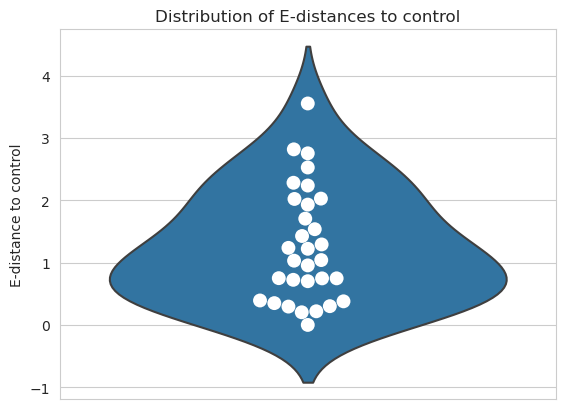

In [15]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=estats.loc['control'], inner=None)
    sns.swarmplot(data=estats.loc['control'], size=10, color='white')
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()

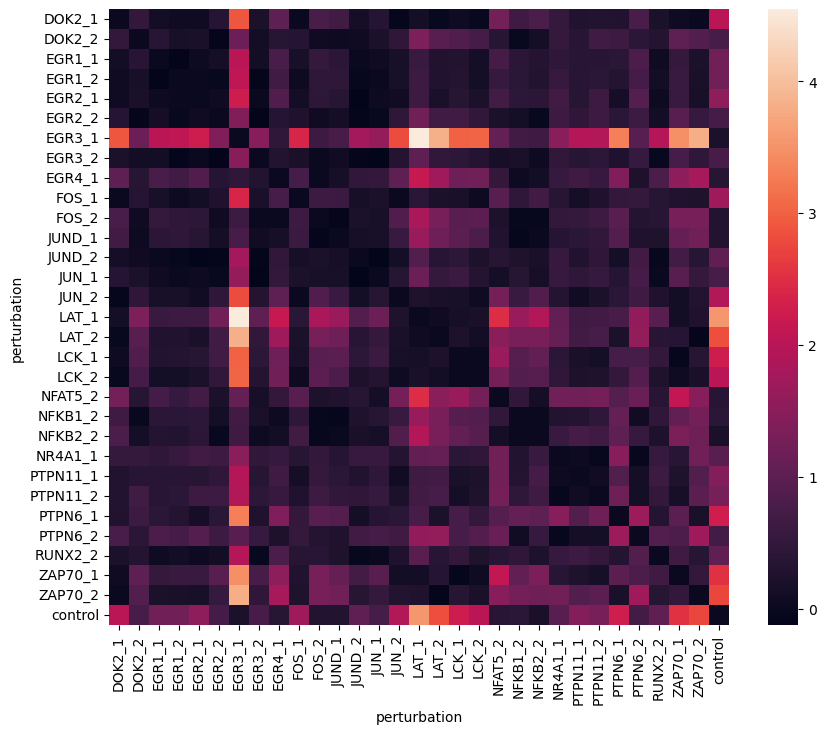

In [16]:
fig, ax = pl.subplots(1,1, figsize=[10,8])
order = estats.sort_index().index
sns.heatmap(estats.loc[order, order])
pl.show()

# E-testing

In [17]:
# e-testing (can be slow)
df = etest(adata, obs_key='perturbation', obsm_key='X_pca', dist='sqeuclidean', control='control', alpha=0.05, runs=1000, n_jobs=-1)

100%|██████████| 1000/1000 [00:07<00:00, 129.30it/s]
/opt/conda/lib/python3.10/site-packages/statsmodels/stats/multitest.py:177: RuntimeWarning: divide by zero encountered in log1p
  np.log1p(-pvals))


In [20]:
df.head()

,edist,pvalue,significant,pvalue_adj,significant_adj
DOK2_1,0.000000,1.000,False,1.000000,False
DOK2_2,0.121912,0.045,True,0.450404,False
EGR1_1,0.160344,0.028,True,0.336727,False
EGR1_2,0.133719,0.051,False,0.466426,False
EGR2_1,0.293057,0.002,True,0.041171,True


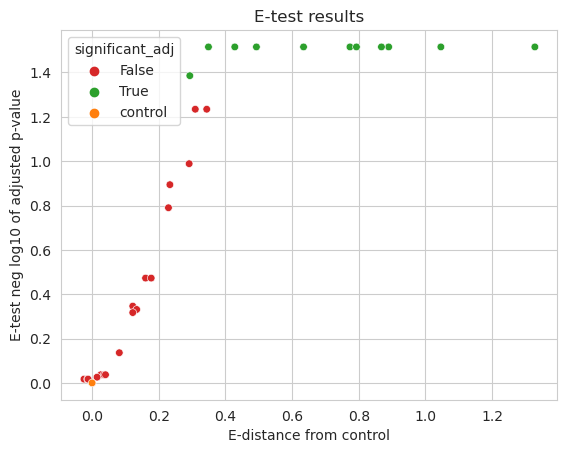

In [21]:
df.loc[df.index=='control', 'significant_adj'] = 'control'
df['neglog10_pvalue_adj'] = -np.log10(df['pvalue_adj'])
with sns.axes_style('whitegrid'):
    sns.scatterplot(data=df, y='neglog10_pvalue_adj', x='edist', hue='significant_adj', palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'}, s=30)
pl.title('E-test results')
pl.xlabel('E-distance from control')
pl.ylabel('E-test neg log10 of adjusted p-value')
pl.show()

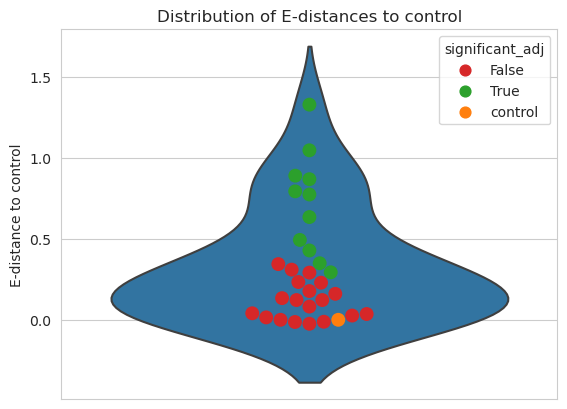

In [22]:
with sns.axes_style('whitegrid'):
    sns.violinplot(data=df, y='edist', inner=None)
    sns.swarmplot(data=df, x=[0]*len(df), y='edist', size=10, hue='significant_adj', dodge=False, palette={True: 'tab:green', False: 'tab:red', 'control': 'tab:orange'})
pl.xticks([0], [''])
pl.ylabel('E-distance to control')
pl.title('Distribution of E-distances to control')
pl.show()